<h4>Máster Big Data, Data Science & Inteligencia Artificial 2024-2025 - UCM</h5>
<h5>Profesores: Gutierrez, Gomez, Castro</h6>
<h5>Alumno: Paez Sheridan, Pablo Santiago</h6>
<h5>Materia: Machine Learning I y II </h6>
<h5>Tarea de Machine Learning parte 1 </h6>

# Tarea - Clasificacion Binaria de Pinturas para Auto

In [ ]:
import random
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from optbinning import BinningProcess
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import StackingClassifier
from tabulate import tabulate

## 1 - Importación y Depuración de Datos

In [2]:
bronze_data = pd.read_excel('../Statement/datos_tarea25.xlsx')

silver_data = bronze_data.copy()  # Crear una copia del dataset original

### Binarizacion de variable objetivo

con el fin de manejar solo valores binarios en la variable objetivo definimos como 1 a White y 0 a Black

In [3]:
silver_data['Color'] = silver_data['Color'].map({'White': 1, 'Black': 0})

### Eliminar variables no representativas

El conjunto de datos no presenta variables identificadoras para eliminar pero la variable Wheel cuenta con solo dos valores de los cuales uno se lleva el 98% de las observaciones. Las RNN y especialmente el algoritmo de maquinas de vector soporte es muy delicado a clases mal representadas por lo que eliminamos la propiedad 'Wheel' del conjunto de datos

In [4]:
silver_data = silver_data.drop(columns=['Wheel'])

### Definir tipo de datos

para cambiar las variables a el tipo de datos correcto en algunos casos tenemos que hacer algunas transformaciones sencillas. 
1. Para el caso de Mileage sacamos el sufijo 'km' de las observaciones 
2. Para el caso de 'Engine Volume' la transforme a numérica sacando la palabra 'Turbo' de done existe para poder lograr la conversion a tipo de dato numérico. Si bien es cierto que esta decision conlleva a una perdida de información la variable consta de 59 tipos de valores lo que conlleva a que ella clases mal representadas a un enorme gasto computacional porque, de ser categóricas, se transformaría en 58 variables dummys.
3. Para el caso de Airbags: la transformamos a categórica porque son solo 12 tipos de observaciones distintas y presentan saltos no lineales debido a que el aumento de los aibags suele estar relacionado con características no lineales como el numero de pasajeros o las posiciones que se quieren asegurar
4. Para el caso de Leather Interior: la mapeamos como binaria ya que sus valores eran si o no. 

In [5]:
# Convertir las columnas a sus tipos de datos correctos
silver_data['Mileage'] = silver_data['Mileage'].str.replace(' km', '').str.replace(',', '').astype(float)  # Convertir Mileage a numérico
silver_data['Engine volume'] = silver_data['Engine volume'].str.replace(' Turbo', '').astype(float)  # Convertir Engine volume a numérico
silver_data['Airbags'] = silver_data['Airbags'].astype('category')
silver_data['Leather interior'] = silver_data['Leather interior'].map({'Yes': 1, 'No': 0})

Para el caso de la variable Levy decidimos tramificar debido a que hay pocas clases que concentran la mayoría de las observaciones y la gran cantidad de datos perdidos.

Para poder definir los tramos que mejor separen las observaciones en base a la variable objetivo 'Color'. El indice que utilizamos es el 'Information Value' usando como criterio un valor mínimo de 0.02 de información por cada tramo y un máximo de 5 tramos. 

Debido a que esta variable presentaba un 15% de datos perdidos decidimos añadir una sexta categoría que represente a todos los datos perdidos de manera que podamos captar la información que quizás la ausencia de valor para esa variable puede significar

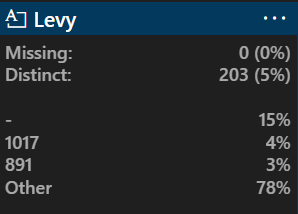

In [6]:
warnings.filterwarnings("ignore", category=FutureWarning)
def levy_stretching(data):
    # Reemplazar "-" por NaN y convertir a numérico
    data['Levy'] = data['Levy'].replace("-", np.nan)
    data['Levy'] = pd.to_numeric(data['Levy'], errors='coerce')

    # Excluir valores nulos de Levy para el binning
    non_null_data = data[data['Levy'].notnull()]

    # Configurar el proceso de binning con el criterio de Information Value (IV)
    binning_process = BinningProcess(
        variable_names=['Levy'],
        selection_criteria={"iv": {"min": 0.02}},
        max_n_bins=5  # Máximo número de bins permitido
    )

    # Ajustar el binning process a los datos no nulos
    binning_process.fit(non_null_data[['Levy']], non_null_data['Color'])

    # Obtener los puntos de corte (splits)
    levy_binned = binning_process.get_binned_variable('Levy')
    binning_table = levy_binned.binning_table
    binning_table.build()
    levy_splits = binning_table.splits

    # Crear etiquetas personalizadas para los tramos
    levy_bins_labels = [f"{float(lower)} - {float(upper)}" for lower, upper in zip([-float('inf')] + list(levy_splits), list(levy_splits) + [float('inf')])]

    # Asignar las etiquetas personalizadas a los tramos
    data['Levy_bins'] = pd.cut(
        data['Levy'],
        bins=[-float('inf')] + list(levy_splits) + [float('inf')],
        labels=levy_bins_labels,
        right=False
    )

    # Añadir un tramo específico para los valores nulos
    data['Levy_bins'] = data['Levy_bins'].cat.add_categories("Missing")
    data['Levy_bins'].fillna("Missing", inplace=True)
    return data.drop(columns=['Levy'])

silver_data = levy_stretching(silver_data)

Para el caso de la variable 'Prod. year' quisimos también hacer una tramificación usando el Information value como criterio para encontrar los puntos de corte optimo pero después de mucho intentar parece haber un problema insalvable con los datos de la variable para poder ser tratados por la función que obtiene los tramos adecuados. 

Frente a esto y la conveniencia de tramificar ya que es una variable que es susceptible de tener saltos no lineales con respecto a la variable objetivo (por ejemplo una regulación que a partir de cierto año en la UE se promueve los autos blancos) decidimos tramificar la variable de manera manual, agrupando los poco autos viejos que había en el primer tramo y tener tramos mas pequeños de ahi en adelante. 

Debido a que la tramificación en este caso no era una decision tan obvia y es cuestionable decidimos mantener también la variable original de manera numérica en el conjunto de datos

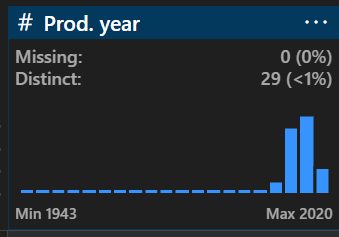

In [7]:
silver_data['Prod. year'] = pd.to_numeric(bronze_data['Prod. year'])

# Asignar los tramos manuales a la columna 'Prod. year'
silver_data['Prod. year_bins'] = pd.cut(
    silver_data['Prod. year'],
    bins=[1943, 2000, 2004, 2008, 2012, 2016, 2020],
    labels=['1943-2000', '2001-2004', '2005-2008', '2009-2012', '2013-2016', '2017-2020'],
    right=True,
    include_lowest=True 
)


### Tratamiento de valores missings

Para el caso de las variables categóricas imputamos en los valores perdidos la moda de cada variable. Para el caso de las variables numéricas imputamos el promedio en cada variable. Este cambio aplica para todas las demás variables que no fuero tratadas de manera especifica en los pasos previos

In [8]:
for column in silver_data.columns:
    if silver_data[column].dtype == 'object':  # Imputar moda para variables categóricas
        silver_data[column].fillna(silver_data[column].mode()[0], inplace=True)
    elif silver_data[column].dtype in ['int64', 'float64']:  # Imputar promedio para variables numéricas
        silver_data[column].fillna(silver_data[column].mean(), inplace=True)

## 2 - Modelización con maquina de vector soporte

### Valores dummies para cada variable categorica

Para cada variable categorica de nuestro conjunto de datos creamos n-1 variables diferentes siendo n el numero total de valores diferentes de la variable categorica en cuestion. 

In [9]:
# 2. Crear columnas dummys para variables categóricas
# Asegurarse de incluir todas las variables categóricas, incluidas las de tipo 'category'
categorical_cols = ['Levy_bins', 'Prod. year_bins', 'Airbags', 'Manufacturer', 'Category', 'Fuel type', 'Drive wheels', 'Gear box type']  # Lista de columnas categóricas
silver_data = pd.get_dummies(silver_data, columns=categorical_cols, drop_first=True)


### Estandarización de variables continuas

Para mejorar la capacidad explicativa de las variables continuas es importante estandarizarlas a todas aplicándoles la misma transformación. En este caso aplicamos la estandarización a escala, es decir las variables van a ir de 0 a 1. 

Si bien es cierto que esta transformación es menor fiel del punto de vista explicativo a la escala original que la transformación normal decidimos aplicar esta transformación porque es mejor para los fines predictivos y los SVM, y los algoritmos de machine learning en general, adolecen, en gran medida, de capacidad explicativa mas no de su uso predictivo

In [10]:
def scale_continuous_variables(data):
    # Estandarizar variables continuas a escala [0, 1]
    scaler = MinMaxScaler()
    numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
    return data

silver_data = scale_continuous_variables(silver_data)

## 2 - Modelización con maquina de vector soporte

Dividimos los conjuntos de datos para train y test usando una semilla de aleatoriedad prefijada y con el shuffle en true para que se mezclen de manera aleatoria antes de dividir los datos

In [11]:
def custom_train_test_split(data):
    Y = data['Color'] 
    X = data.drop(columns=['Color'])
    SEED = 12345
    random.seed(SEED)
    np.random.seed(SEED)
    return train_test_split(X, Y, test_size=0.25, shuffle=True, random_state=SEED)

X_train, X_test, Y_train, Y_test = custom_train_test_split(silver_data)

### Modelo SVM con kernel lineal

Usamos el modelo de maquina de vector soporte mas sencillo, el kernel lineal, el cual busca separar los conjuntos de los problemas de clasificación mediante una función lineal. Es bastante similar a un modelo de regresión lineal.

Para lograr un modelo mas robusto y con poco sesgo partimos de la premisa de mantenernos con una C pequeña de manera que el modelo tenga cierta tolerancia a observaciones mal clasificadas en la frontera de la separación.

Fuimos variando para encontrar el SVM lineal optimo

In [12]:
def svm_linear(X_train, Y_train, X_test,C):
    svm_linear = SVC(kernel='linear', C=C, random_state=12345, probability=True)
    svm_linear.fit(X_train, Y_train)
    y_pred_linear = svm_linear.predict(X_test)
    y_proba_linear = svm_linear.predict_proba(X_test)[:, 1]
    return  y_pred_linear,y_proba_linear

y_pred_linear, y_proba_linear = svm_linear(X_train, Y_train, X_test, 0.1)

print("Resultados SVM Kernel Lineal con C=0.1:")
print("Accuracy:", accuracy_score(Y_test, y_pred_linear))
print("AUC:", roc_auc_score(Y_test, y_proba_linear))
print(classification_report(Y_test, y_pred_linear))

Resultados SVM Kernel Lineal con C=0.1:
Accuracy: 0.6497695852534562
AUC: 0.6823523369286081
              precision    recall  f1-score   support

         0.0       0.69      0.66      0.67       590
         1.0       0.61      0.64      0.63       495

    accuracy                           0.65      1085
   macro avg       0.65      0.65      0.65      1085
weighted avg       0.65      0.65      0.65      1085



In [13]:
y_pred_linear, y_proba_linear = svm_linear(X_train, Y_train, X_test, 0.5)

print("Resultados SVM Kernel Lineal con C=0.5:")
print("Accuracy:", accuracy_score(Y_test, y_pred_linear))
print("AUC:", roc_auc_score(Y_test, y_proba_linear))
print(classification_report(Y_test, y_pred_linear))



Resultados SVM Kernel Lineal con C=0.5:
Accuracy: 0.6580645161290323
AUC: 0.6855743879472692
              precision    recall  f1-score   support

         0.0       0.69      0.67      0.68       590
         1.0       0.62      0.65      0.63       495

    accuracy                           0.66      1085
   macro avg       0.66      0.66      0.66      1085
weighted avg       0.66      0.66      0.66      1085



In [14]:
y_pred_linear, y_proba_linear = svm_linear(X_train, Y_train, X_test, 2)

print("Resultados SVM Kernel Lineal con C=2:")
print("Accuracy:", accuracy_score(Y_test, y_pred_linear))
print("AUC:", roc_auc_score(Y_test, y_proba_linear))
print(classification_report(Y_test, y_pred_linear))

Resultados SVM Kernel Lineal con C=2:
Accuracy: 0.6599078341013825
AUC: 0.6861171032357474
              precision    recall  f1-score   support

         0.0       0.69      0.68      0.68       590
         1.0       0.62      0.64      0.63       495

    accuracy                           0.66      1085
   macro avg       0.66      0.66      0.66      1085
weighted avg       0.66      0.66      0.66      1085



El mejor modelo SVM lineal es con la C es 2. Pero las mejoras son apenas perceptibles por lo que considero que no vale la pena seguirla aumentando en detrimento de la robustez del modelo. Un c pequeña siempre favorece a que el modelo tenga menor sesgo debido a que penaliza menos las observaciones mal clasificadas

### SVM con kernel Polinómico

Optamos por probar el kernel polinómico el cual intenta clasificar las observaciones mapeándolas a un plano de mayor grado y obteniendo una función polinómica de determinado grado para poder separar las observaciones .

Las variantes que se pueden probar en un SVM polinómico son entonces el grado del polinomio separador y la C que tiene la misma función que en el SVM lineal, es un penalizador de las observaciones mal clasificadas. Mientras mas alta mas el modelo intenta separar las observaciones siendo menos tolerantes a observaciones mal clasificadas.

Siguiendo la misma premisa de mantener la C relativamente baja para poder tener un modelo robusto y no tan sesgado probamos diferentes alternativas del svm polinómico

In [15]:
def svm_poly(X_train, Y_train, X_test, degree, C):
    svm_poly = SVC(kernel='poly', degree=degree,C=C, random_state=12345, probability=True)
    svm_poly.fit(X_train, Y_train)
    y_pred_poly = svm_poly.predict(X_test)
    y_proba_poly = svm_poly.predict_proba(X_test)[:, 1]
    return y_pred_poly, y_proba_poly

In [16]:
y_pred_poly, y_proba_poly = svm_poly(X_train, Y_train, X_test, degree=2, C=2)

print("Resultados SVM Kernel Polinómico de grado 2 y con C=2:")
print("Accuracy:", accuracy_score(Y_test, y_pred_poly))
print("AUC:", roc_auc_score(Y_test, y_proba_poly))
print(classification_report(Y_test, y_pred_poly))

Resultados SVM Kernel Polinómico de grado 2 y con C=2:
Accuracy: 0.687557603686636
AUC: 0.7411573360725904
              precision    recall  f1-score   support

         0.0       0.71      0.71      0.71       590
         1.0       0.66      0.66      0.66       495

    accuracy                           0.69      1085
   macro avg       0.69      0.69      0.69      1085
weighted avg       0.69      0.69      0.69      1085



In [17]:
y_pred_poly, y_proba_poly = svm_poly(X_train, Y_train, X_test, degree=2, C=3)

print("Resultados SVM Kernel Polinómico de grado 2 y con C=3:")
print("Accuracy:", accuracy_score(Y_test, y_pred_poly))
print("AUC:", roc_auc_score(Y_test, y_proba_poly))
print(classification_report(Y_test, y_pred_poly))

Resultados SVM Kernel Polinómico de grado 2 y con C=3:
Accuracy: 0.6894009216589861
AUC: 0.7426656394453005
              precision    recall  f1-score   support

         0.0       0.72      0.71      0.71       590
         1.0       0.66      0.67      0.66       495

    accuracy                           0.69      1085
   macro avg       0.69      0.69      0.69      1085
weighted avg       0.69      0.69      0.69      1085



In [18]:
y_pred_poly, y_proba_poly = svm_poly(X_train, Y_train, X_test, degree=3, C=2)

print("Resultados SVM Kernel Polinómico de grado 3 y con C=2:")
print("Accuracy:", accuracy_score(Y_test, y_pred_poly))
print("AUC:", roc_auc_score(Y_test, y_proba_poly))
print(classification_report(Y_test, y_pred_poly))

Resultados SVM Kernel Polinómico de grado 3 y con C=2:
Accuracy: 0.7059907834101382
AUC: 0.7536380756719739
              precision    recall  f1-score   support

         0.0       0.73      0.73      0.73       590
         1.0       0.68      0.67      0.68       495

    accuracy                           0.71      1085
   macro avg       0.70      0.70      0.70      1085
weighted avg       0.71      0.71      0.71      1085



Como podemos observar el SVM de grado 3 es algo superior tanto en el Area bajo de la curva ROC como también en la Precision de las predicciones

### Comparación de los kernels de SVM

Para poder observarlo de manera gráfica generamos un diagrama con las dos curvas AUC de los mejores configuraciones paramétricas de ambos kernels, el lineal y el polinómico

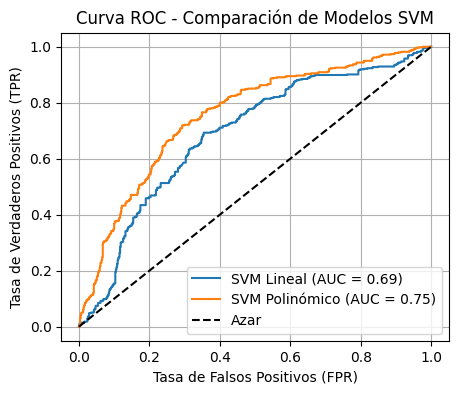

In [27]:
fpr_linear, tpr_linear, _ = roc_curve(Y_test, y_proba_linear)
fpr_poly, tpr_poly, _ = roc_curve(Y_test, y_proba_poly)

plt.figure(figsize=(5, 4))
plt.plot(fpr_linear, tpr_linear, label='SVM Lineal (AUC = {:.2f})'.format(roc_auc_score(Y_test, y_proba_linear)))
plt.plot(fpr_poly, tpr_poly, label='SVM Polinómico (AUC = {:.2f})'.format(roc_auc_score(Y_test, y_proba_poly)))
plt.plot([0, 1], [0, 1], 'k--', label='Azar')
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC - Comparación de Modelos SVM')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

Como podemos observar ambos modelos son bastante buenos siendo el SVM Polinómico superior no solo en AUC sino también en Accuracy.

### Bagging del modelo ganador

Aplicando la técnica del Bagging al el modelo SVM polinómico nos aseguramos de reducir la varianza para poder tener un modelo mas robusto que se comporte de manera similar sin importar el conjunto de datos que reciba y que no este sesgado exclusivamente el conjunto de entrenamiento

Utilizaremos 10 modelos estimadores de kernel polinómico cada uno entrenado con diferentes conjuntos de datos(n_estimators). Cada uno de estos modelos se entrenara con el 80% de los datos (max_samples). Todos los modelos tendrán a disposición la totalidad de las características del conjunto de datos (max features). Las muestras de entrenamiento se obtienen seleccionando de manera aleatoria las observaciones permitiendo que una sea seleccionada en mas de una sesión de entrenamiento (boostrap)

In [20]:
def bagging_svm(X_train, Y_train, X_test, Y_test, degree=3, C=2):
    # Crear un clasificador SVM base
    base_model = SVC(kernel='poly', probability=True, degree=degree, C=C ,random_state=12345)

    # Crear el modelo de Bagging
    bagging_model = BaggingClassifier(
        estimator=base_model,
        n_estimators=10,  # Número de modelos base
        max_samples=0.8,  # Proporción de muestras para cada modelo base
        max_features=1.0,  # Proporción de características para cada modelo base
        bootstrap=True,  # Usar muestreo con reemplazo
        random_state=54321  # Semilla para la aleatoriedad
    )

    # Ajustar el modelo de Bagging a los datos de entrenamiento
    bagging_model.fit(X_train, Y_train)

    # Predecir en los datos de prueba
    y_pred_bagging = bagging_model.predict(X_test)
    y_proba_bagging = bagging_model.predict_proba(X_test)[:, 1]

    # Calcular métricas
    accuracy_bagging = accuracy_score(Y_test, y_pred_bagging)
    auc_bagging = roc_auc_score(Y_test, y_proba_bagging)
    report_bagging = classification_report(Y_test, y_pred_bagging)

    return accuracy_bagging, auc_bagging, report_bagging

accuracy_bagging, auc_bagging, report_bagging = bagging_svm(X_train, Y_train, X_test, Y_test)

print("Resultados Bagging sobre SVM Kernel Polinómico:")
print(f"Accuracy: {accuracy_bagging}")
print(f"AUC: {auc_bagging}")
print(report_bagging)

Resultados Bagging sobre SVM Kernel Polinómico:
Accuracy: 0.6949308755760368
AUC: 0.7648005478513953
              precision    recall  f1-score   support

         0.0       0.71      0.74      0.72       590
         1.0       0.67      0.64      0.66       495

    accuracy                           0.69      1085
   macro avg       0.69      0.69      0.69      1085
weighted avg       0.69      0.69      0.69      1085



El modelo obtenido es ligeramente mejor en el desempeño de el area bajo de la curva ROC y el accuracy es ligeramente inferior. Pero en ambos casos las medidas son casi idénticas el modelo SVM polinómico de grado 3 entrenado originalmente pero probablemente mas robusto antes nuevas observaciones al ser entrenado con un conjunto de datos superior y en un mayor numero de corridas

## 3 - Stacking en profundidad

### Analisis de correlacion entre los clasificadores candidatos

Para hacer un buen stacking de profundidad debemos primero elegir bien los modelos clasificadores cuyas predicciones luego van a ser sopesadas por el meta modelo de stacking elegido. 

Un parte importante de esta elección de los clasificadores es evaluar la correlación de sus predicciones de manera tal que solo nos quedamos con aquellos clasificadores que no se encuentran en exceso correlados y que por lo tanto, en su conjunto, no aportan demasiada información.

Para poder hacer esto obtenemos las predicciones de cada modelo clasificador sopesado y hacemos una matriz de correlación para poder evaluarlos.

Los modelos clasificadores candidatos son los siguientes

1. Maquina de Vector soporte polinómica de grado 3 con un C=2
2. Regresión Logística
3. Random Forest
4. KNN
5. Árbol de decision
6. Clasificador Naive Bayes

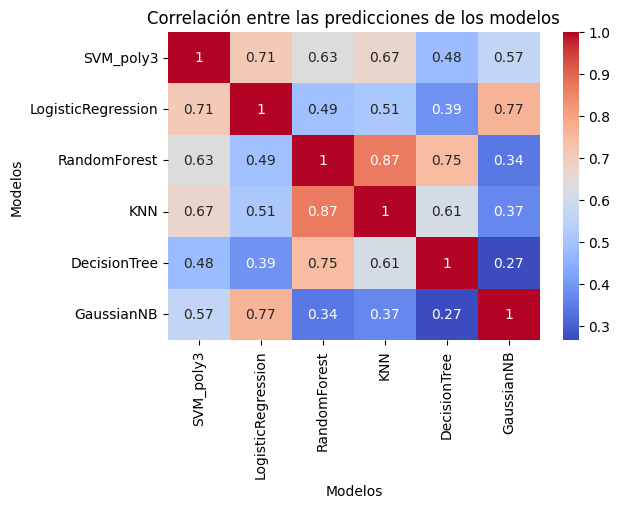

In [28]:
def calcular_matriz_correlacion(X_train, Y_train, X_test):
    base_models = {
        "SVM_poly3": SVC(kernel='poly', degree=3, C=2, probability=True, random_state=12345),
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=12345),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=12345),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "DecisionTree": DecisionTreeClassifier(random_state=12345),
        "GaussianNB": GaussianNB()
    }
    predictions = {}
    for name, model in base_models.items():
        model.fit(X_train, Y_train)
        proba = model.predict_proba(X_test)[:, 1]
        predictions[name] = proba
    df_predictions = pd.DataFrame(predictions)
    correlation = df_predictions.corr()
    return correlation

# Invocación y visualización
correlation = calcular_matriz_correlacion(X_train, Y_train, X_test)
plt.figure(figsize=(6,4))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title("Correlación entre las predicciones de los modelos")
plt.xlabel("Modelos")
plt.ylabel("Modelos")
plt.show()

Podemos observar que no existe una elevada correlación entre ninguno de los modelos a excepción de el KNN y el Random Forest. 

Debido a su elevada correlación podemos decir que ambos modelos aportan casi las mismas predicción y que no son complementario ni van a aportar mucho, su conjunto, a mejorar las predicciones en la futura combinación de los modelos, debemos elegir con que modelo quedarnos y cual ignorar.

Para esto lo mejor es evaluar el rendimiento de estos modelos y quedarnos con el que consideramos mejor. A continuación obtendremos la precision un gráfico de la curva ROC para estos dos modelos en base a el conjunto de datos que fue depurado en pasos anteriores

Random Forest - Accuracy: 0.788, AUC: 0.878
KNN           - Accuracy: 0.747, AUC: 0.813


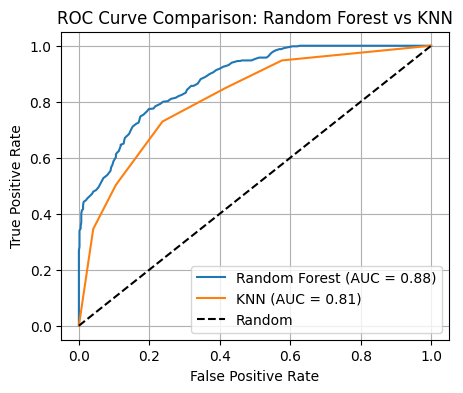

In [25]:
# Compare Random Forest and KNN: plot ROC curves and print accuracy/AUC

# Train Random Forest
def CompareRandomForestKNN():
    rf_model = RandomForestClassifier(n_estimators=100, random_state=12345)
    rf_model.fit(X_train, Y_train)
    rf_pred = rf_model.predict(X_test)
    rf_proba = rf_model.predict_proba(X_test)[:, 1]
    rf_acc = accuracy_score(Y_test, rf_pred)
    rf_auc = roc_auc_score(Y_test, rf_proba)

    # Train KNN
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, Y_train)
    knn_pred = knn_model.predict(X_test)
    knn_proba = knn_model.predict_proba(X_test)[:, 1]
    knn_acc = accuracy_score(Y_test, knn_pred)
    knn_auc = roc_auc_score(Y_test, knn_proba)

    # Print metrics
    print(f"Random Forest - Accuracy: {rf_acc:.3f}, AUC: {rf_auc:.3f}")
    print(f"KNN           - Accuracy: {knn_acc:.3f}, AUC: {knn_auc:.3f}")

    # Plot ROC curves
    fpr_rf, tpr_rf, _ = roc_curve(Y_test, rf_proba)
    fpr_knn, tpr_knn, _ = roc_curve(Y_test, knn_proba)

    plt.figure(figsize=(5,4))
    plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.2f})')
    plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {knn_auc:.2f})')
    plt.plot([0,1],[0,1],'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison: Random Forest vs KNN')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

CompareRandomForestKNN()

Es bastante claro que el clasificador mas destacable es el Random Forest ya que es mejor, no solo en la precision, sino también en el area bajo la curva. Ambos modelos son decentes pero el Random Forest se impone con un 0.88 frente a un 0.81 del KNN indicando que es superior en términos de las tasas observaciones predichas como verdaderos positivos en relación a aquellas predichas como falsos positivos

### Stacking con los clasificadores seleccionados

Vamos a utilizar la función Stacking Clasiffier para hacer un stacking automático teniendo como estimadores seleccionados todos los candidatos previamente enunciados descartando el KNN. 

Para realizar el stacking automático seteamos el passtrough en False para que no incorpore las variables originales del modelo, queremos tener un stacking puro que trabaje solo con las predicciones de los modelos clasificadores para evaluar la capacidad que tiene de mejorar el modelo complementándolos sin hacer uso de otra cosa que no sean las predicciones. EL metamodelo para realizar la clasificación final en base a las predicciones de los clasificadores del stacking sera una regresión Logística, por ser un buen clasificador asi como un modelo sencillo y muy usado como meta-modelo en estos casos

En el algoritmo vamos guardando ademas las predicciones de cada uno de los modelos clasificadores por separado para poder generar una tabla comparativa de su precision y su AUC con las respectivas medidas de desempeño del Stacking. Lo mismo hago para generar una gráfico de la curva ROC para todos los modelos clasificadores asi como el Stacking


Stacking - Accuracy: 0.783, AUC: 0.878

Summary of Model Performance:
           Model  Accuracy       AUC
0  SVMPolinomico  0.705991  0.753638
1   RegLogistica  0.662673  0.698428
2   RandomForest  0.788018  0.877812
3  ArbolDecision  0.751152  0.750205
4     NaiveBayes  0.593548  0.661263
5       Stacking  0.783410  0.878141


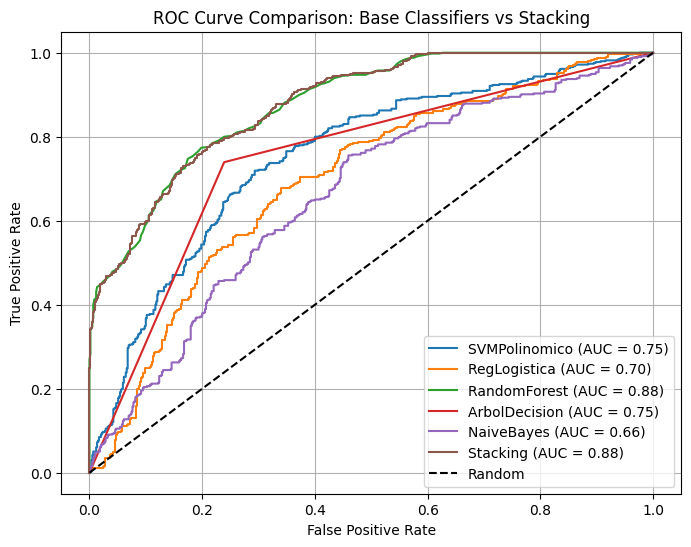

In [26]:
def CustomStackingClassifier(X_train, Y_train, X_test, Y_test):
    estimators = [
        ('SVMPolinomico', SVC(kernel='poly', degree=3, C=2, probability=True, random_state=12345)),
        ('RegLogistica', LogisticRegression(max_iter=1000, random_state=12345)),
        ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=12345)),
        ('ArbolDecision', DecisionTreeClassifier(random_state=12345)),
        ('NaiveBayes', GaussianNB())
    ]

    results = []
    roc_curves = {}

    for name, model in estimators:
        model.fit(X_train, Y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        acc = accuracy_score(Y_test, y_pred)
        auc = roc_auc_score(Y_test, y_proba)
        results.append({'Model': name, 'Accuracy': acc, 'AUC': auc})
        fpr, tpr, _ = roc_curve(Y_test, y_proba)
        roc_curves[name] = (fpr, tpr)

    stacking_clf = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(max_iter=1000, random_state=12345),
        cv=5,
        passthrough=False,
        stack_method='auto'
    )
    stacking_clf.fit(X_train, Y_train)
    y_pred_stack = stacking_clf.predict(X_test)
    y_proba_stack = stacking_clf.predict_proba(X_test)[:, 1]
    acc_stack = accuracy_score(Y_test, y_pred_stack)
    auc_stack = roc_auc_score(Y_test, y_proba_stack)
    results.append({'Model': 'Stacking', 'Accuracy': acc_stack, 'AUC': auc_stack})
    fpr_stack, tpr_stack, _ = roc_curve(Y_test, y_proba_stack)
    roc_curves['Stacking'] = (fpr_stack, tpr_stack)

    print("\nStacking - Accuracy: {:.3f}, AUC: {:.3f}".format(acc_stack, auc_stack))

    results_df = pd.DataFrame(results)
    print("\nSummary of Model Performance:")
    print(results_df)

    plt.figure(figsize=(8, 6))
    for name, (fpr, tpr) in roc_curves.items():
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc_score(Y_test, stacking_clf.predict_proba(X_test)[:, 1]) if name == 'Stacking' else roc_auc_score(Y_test, estimators[[n for n, _ in estimators].index(name)][1].predict_proba(X_test)[:, 1]):.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison: Base Classifiers vs Stacking')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


CustomStackingClassifier(X_train, Y_train, X_test, Y_test)

## 4 - Comparación final

### Evaluación de los modelos de maquinas de vector soporte

| Modelo                   | Accuracy |   AUC   |
|--------------------------|----------|---------|
| SVM Lineal               | 0.660    | 0.686   |
| SVM Polinómico           | 0.706    | 0.754   |
| SVM Polinómico + Bagging | 0.695    | 0.765   |

El modelo de maquina vector soporte es un modelo muy dependiente de la parametrización y la experimentación entras las diferentes configuraciones paramétricas. Es un modelo que hay que entender como se usa para poder aprovecharlo. 

En ese contexto al probar el SVM Lineal nos dimos cuenta que si bien modificando la C para que penalize mas las clasificaciones mal observadas mejorábamos algo la precision esa mejora era cada vez menos sustancial con la desventaja de cada vez corríamos mas riesgo de sesgar el modelo. Es asi como concluimos que el punto optimo de C=2 alcanzando una precision del 0.660. Este numero no es algo muy significativo ya si nuestro modelo de clasificación fuera de tirar una moneda al aire probablemente tendríamos una precision rondando los 0.5. Es decir el SVM Lineal que logramos obtener es algo mejor que tirar una moneda al aire.

Con el SVM Polinómico nos fue mucho mejor, la capacidad de ubicar las observaciones en un plano de grado superior permitiendo que el separador no sea ya una recta sino un multiplano, en este caso de tipo polinómico, permite que se puedan encontrar patrones de separación mucho mas complejos y que se puedan separar mejor las observaciones. 

Al igual que con el SVM Lineal en el SVM Polinómico es muy importante encontrar las configuraciones paramétricas correctas. El grado 3 era significativamente mejor que el polinomio de grado 2 y al ir subiendo la C llegamos al punto (C=2) donde la penalización de las observaciones mal observadas ya no hacia incrementar de manera significativa la precision o el AUC como para que justifique seguir sesgando el modelo ajustándose demasiado al conjunto de datos de entrenamiento.

Al añadir el Bagging a el modelo polinómico que decidimos como el mejor (grado 3 con C=2) la precision no mejoro, como era de esperarse, ya que no es este el propósito del bagging sino mas bien el objetivo es entrenarlo al modelo con multiples conjuntos de datos distintos para contrarrestar el sesgo que el mismo pudiese tener haciendo un modelo mas robusto. El hecho de que la precision y el AUC se hayan mantenido cerca de los valores del modelo original, incluso el AUC mejor un poco, nos permite indicar que el Bagging es un éxito y que este mejoro al SVM polinómico original

### Evaluacion del modelo Stacking y los modelos discriminantes usados
| Modelo           | Accuracy |   AUC   |
|------------------|----------|---------|
| SVM Polinómico   | 0.706    | 0.754   |
| Regresión Logística | 0.663 | 0.698   |
| Random Forest    | 0.788    | 0.878   |
| Árbol Decisión   | 0.751    | 0.750   |
| Naive Bayes      | 0.594    | 0.661   |
| Stacking         | 0.783    | 0.878   |




Para elegir los diversos clasificadores candidatos a formar parte del modelo stacking partimos de los modelos que fuimos dando a lo largo de este master el único que añadí por fuera de los dictados es el de Naive Bayes por su sencillez y por que entendía como funcionaba. 

Antes de proceder a hacer el Stacking en si decidí analizar la correlación de los mismos y al ver que el KNN y el Random Forest estaban correlados, luego de evaluar el desempeño de cada modelo por separado, decidí quedarme con el Random Forest en el stacking y sacar el KNN de los modelos clasificadores.

La precision y el AUC del modelo stacking es prácticamente la misma que el mejor de los clasificadores (el Random Forest). Esto a primera vista me pareció un poco decepcionante pero la verdad es que el Random Forest ya tenia unas medidas de desempeño increíbles por lo que es fácil suponer que los otros modelos poco y nada tenían que aportar a sus predicciones. De hecho es interesante observar que el stacking no se dejo llevar por las malas predicciones de los otros modelos mucho peores al Random Forest, como el de Naive Bayes por ejemplo, empeorando las medidas de desempeño del Random Forest.

### Conclusion final

A lo largo de estas paginas pude aprender las diferencias que existen entre los modelos de machine learning a los modelos predictivos clásicos. Me llamo la atención la gran capacidad para abarcar la complejidad de los conjuntos de datos y encontrar patrones en variable predictoras que, a simple vista, poco o nada pueden tener que ver con la variable objetiva. 

A si como me di cuenta de la superioridad que estos modelos presentan en capacidad predictiva con conjunto de datos complejos también pude aprender de las debilidades y riesgos que estos modelos traen consigo como son la inmensa dificultad de obtener un modelo comprensible y explicativo en si mismo asi como el riesgo que existe en caer en el sobre ajuste debido a la gran capacidad de estos modelos de ajustarse, a veces de sobre manera a los conjuntos de datos propuestos.

Frente a estas desventajas también aprendí la importancia de conocer el funcionamiento de los modelos en profundidad para hallar las mejores configuraciones paramétricas posibles teniendo cuidado en no caer en el sobre ajuste y aplicando técnicas, como el bagging, para reducir el sesgo de nuestros modelos. ¿